# Downside measures

In [13]:
import pandas as pd
import risk_kit as kit
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hfi = kit.get_hfi_returns()

# Semideviation

In [3]:
#Semideviation is the average spread, the average deviation from the mean.
hfi.std(ddof=0)

Convertible Arbitrage     0.016536
CTA Global                0.023290
Distressed Securities     0.017009
Emerging Markets          0.032476
Equity Market Neutral     0.008115
Event Driven              0.016712
Fixed Income Arbitrage    0.011517
Global Macro              0.014694
Long/Short Equity         0.019897
Merger Arbitrage          0.009600
Relative Value            0.011462
Short Selling             0.047655
Funds Of Funds            0.015536
dtype: float64

In [5]:
#If the Semi-deviation goes above, it is good. We only get concerned when the return goes below average.

In [6]:
# filter returns less than 0 and compute standard deviation
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [11]:
kit.semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

# VaR and CVaR

- Historic VaR
- Parametric VaR - Gaussian
- Modified VaR [Cornish-Fisher VaR]

In [14]:
# Historic VaR
np.percentile(hfi, 5)  # computs q-th percentile of the input array along the specified axis.

-0.0274

In [15]:
np.percentile(hfi, 5, axis=0) 

array([-0.01576, -0.03169, -0.01966, -0.04247, -0.00814, -0.02535,
       -0.00787, -0.01499, -0.02598, -0.01047, -0.01174, -0.06783,
       -0.02047])

Here, this can be interpreted as Eg: for the first one Convertible Arbitrage, there is a 5% chance in any given month, you are going to lose about 1.5% or worse.

In [21]:
def var_historic(r, level=5):
    """
    Return the historic value at Risk at a specified level 
    i.e; returns the number such that "level" percent of the returns fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level) # -ve since we always express it as a positive number
    else:
        raise TypeError("Expected r to be Series or DataFrame")

In [22]:
var_historic(hfi, 5)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

In [23]:
# Scipy.stats has support for modeling the normal distribution.
from scipy.stats import norm

In [24]:
norm.ppf(.05)  #Signature: norm.ppf(q, *args, **kwds), Docstring: Percent point function (inverse of `cdf`) at q of the given RV.

-1.6448536269514729

This returns the actual z-score. 

In [25]:
# For a normal distribution, the z-score associated where 
# half of the distribution lies below the mean, will be a z-score of zero
norm.ppf(.5) 

0.0

In [30]:
#Value a Risk at 5% level
z = norm.ppf(.05)
VaR_Gaussian = -(hfi.mean() + z*hfi.std(ddof=0))

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

# Cornish-Fisher

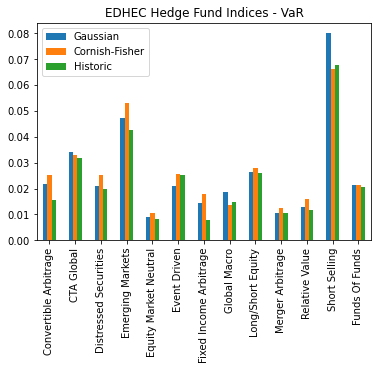

In [32]:
var_list = [kit.var_gaussian(hfi), kit.var_gaussian(hfi, modified=True), kit.var_historic(hfi)]
comparison = pd.concat(var_list, axis=1)
comparison.columns = ['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title= "EDHEC Hedge Fund Indices - VaR")

Comparing Cornish-Fisher and Gaussian, when Cornish-Fisher has higher value, it is high Value at risk. When Cornish-Fisher decrease compared to the stated VaR, it is all a function of whether the skewness is +ve or -ve, the extend of it, how fat the tails are etc.

# Beyond VaR aka CVaR

Once you have computed the VaR, CVar is nothing more than the average of all those returns that are worse than the VaR

In [35]:
kit.cvar_historic(hfi)

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64

This says, if that 5% chance happens, ie; the worst 5% of the possible cases, the average of that is a 3.6% loss in a month if invested in the convertible arbitrage hedge fund.